update:
1. try Resnet-152
2. best accuracy 96%


In [0]:
!pip install Pillow==5.3.0

In [65]:
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [67]:
!pip install torchvision

In [68]:
# Use PyTorch to check versions, CUDA version and cuDNN

import torch

print("PyTorch version: ")
print(torch.__version__)
print("CUDA Version: ")
print(torch.version.cuda)
print("cuDNN version is: ")
print(torch.backends.cudnn.version())

PyTorch version: 
0.4.1
CUDA Version: 
9.2.148
cuDNN version is: 
7104


In [69]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
   print('CUDA is not available.  Training on CPU ...')
else:
   print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [70]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls "/content/drive/My Drive/Colab Notebooks"

In [0]:
# Imports here
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets,models,transforms

import matplotlib.pyplot as plt
import os
import time
import copy

import json

%matplotlib inline
plt.ion()

In [0]:
#define hyper-parameters
batch_size = 64
num_worker = 4
learn_rate = 0.002
N_epochs = 60

#---------------------------starts the trainning phase------------------------------#

In [0]:
#-----------------------loading data--------------------#
data_dir = '/content/drive/My Drive/Colab Notebooks/flower_data'
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
}
image_datasets = {
                x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','valid']
}
dataloaders = {
                x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size, shuffle = True, num_workers = num_worker)
                for x in ['train','valid']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

In [0]:

#---------------------define model------------------------#
ClassifierModel = models.resnet152(pretrained = True)
for param in ClassifierModel.parameters():
    param.requires_grad = False
    
num_ftr = ClassifierModel.fc.in_features
ClassifierModel.fc = nn.Sequential(
                                    nn.Linear(num_ftr,1000),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(1000,102)
                                  )

criterion = nn.CrossEntropyLoss()

#optimizer = optim.Adam(ClassifierModel.classifier.parameters(),lr = learn_rate)
optimizer = optim.SGD(ClassifierModel.fc.parameters(),lr = learn_rate,momentum = 0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=0.8*N_epochs, gamma=0.5)


In [0]:
#---------------------define device-----------------------#
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )
ClassifierModel.to(device)

In [0]:
#------------------helper function : model train------------------#
def train_model(model,criterion, optimizer, scheduler, num_epochs):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    batch = 0
    best_epoch = 0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*10)
        start_epoch = time.time()
        
        #each epoch has trainning and validation phase
        for phase in ['train','valid']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else :
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            #iterate over data
            for inputs, labels in dataloaders[phase]:
                start_batch = time.time()
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                batch += 1
                #zero the parameter gradients
                optimizer.zero_grad()
                #forward prop.
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)
                    
                #backward prop.
                    if phase =='train':
                        loss.backward()
                        optimizer.step()
                        
                #statistics
                running_loss +=loss.item()*inputs.size(0)
                running_corrects +=torch.sum(preds == labels.data)
                #print('Batch {} : {}'.format(batch,time.time() - start_batch))
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))
                  #'Epoch_time:',time.time()-start_epoch)
                 
            
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc :
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
    print('Best val Acc: {:4f} at epoch {}'.format(best_acc,best_epoch+1))
            
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
            

In [0]:
# ---------------------train the model to get a good classifier--------------------------#
ClassifierModel = train_model(ClassifierModel, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=N_epochs)

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/cat_to_name.json', 'r') as f:
    class_names = json.load(f)
  
ClassifierModel.class_to_idx = image_datasets['train'].class_to_idx

In [0]:
#-------------------------save the model for resumming training or inference---------------------#
torch.save({
            'epoch': 60,
            'model_state_dict': ClassifierModel.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            
            }, '/content/drive/My Drive/Colab Notebooks/Classifier_Resnet152.pth.tar')




#------------------------starts inference phase---------------------------#





In [81]:
#------------------------load the model for resumming training or inference-----------------------#
TestModel = models.resnet152(pretrained = True)
for param in TestModel.parameters():
    param.requires_grad = False
    
num_ftr = TestModel.fc.in_features
TestModel.fc = nn.Sequential(
                                    nn.Linear(num_ftr,1000),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(1000,102)
                                  )

TestOptimizer = optim.SGD(TestModel.fc.parameters(),lr = learn_rate,momentum = 0.9)

#checkpoint = torch.load('/content/drive/My Drive/Colab Notebooks/Classifier_Resnet152.pth.tar')
checkpoint = torch.load('/content/drive/My Drive/Colab Notebooks/Classifier_Resnet152.pth')
TestModel.load_state_dict(checkpoint['model_state_dict'])
#TestOptimizer.load_state_dict(checkpoint['optimizer_state_dict'])

TestModel.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

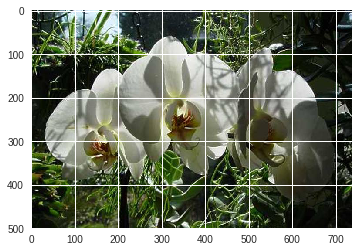

In [82]:
from PIL import Image
test_data_dir = '/content/drive/My Drive/Colab Notebooks/flower_data/test'
pil_image = Image.open('/content/drive/My Drive/Colab Notebooks/flower_data/test/7/image_07216.jpg')
plt.imshow(pil_image)

In [83]:
def process_image(pil_image):
    #resize the image with shorter side of 256 px
    width, height = pil_image.size
    if width <= height :
      pil_image.thumbnail((256*float(height/width),256*float(height/width)))
    else :
      pil_image.thumbnail((256*float(width/height),256*float(width/height)))
      
    # center crop the image with 224 px
    width, height = pil_image.size 
    left = np.ceil((width - 224)/2)
    top = np.ceil((height - 224)/2)
    right = np.ceil((width + 224)/2)
    bottom = np.ceil((height + 224)/2)
    pil_image = pil_image.crop((left, top, right, bottom))
    
    # To Tensor
    np_image = np.array(pil_image)/255
    
    # Normalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean)/std
    
    # transpose the color channel
    np_image = np.transpose(np_image,(2,0,1))
    
    return np_image
    
  
np_image = process_image(pil_image)
#plt.imshow(test_pil)
print (np_image.shape)


(3, 224, 224)


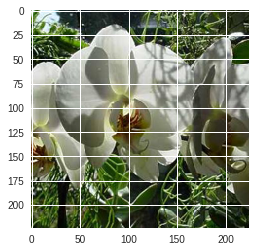

In [84]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
  
imshow(np_image)

In [85]:
#--------------------Class Prediction------------------------------
def predict(np_image, model, topk=5):
    torch_image = torch.from_numpy(np_image).float()
    torch_image = torch_image.unsqueeze(0)
    scores = model(torch_image)   
    m = nn.Softmax()
    probs = m(scores)
    Top_ps,Top_class = probs.topk(topk,dim=1)
    
    return Top_ps,Top_class
  
Tp_ps,Tp_cls = predict(np_image, TestModel)
print(Tp_ps)
print(Tp_cls)


tensor([[0.6785, 0.0658, 0.0575, 0.0496, 0.0466]], grad_fn=<TopkBackward>)
tensor([[69, 66, 88, 25, 75]])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
